This notebook demonstrates a complete pipeline for **Detecting Cyberbullying in Bangla-English social media comments** using deep learning and natural language processing. It begins by loading and exploring a dataset of online comments, then applies thorough text preprocessing to clean and normalize the data, including the removal of URLs, punctuation, numbers, emojis, and both Bangla and English stopwords. The workflow continues with visualizations that reveal the distribution of labels and comment lengths, helping to understand the dataset’s characteristics. For feature extraction, the notebook leverages a multilingual BERT model to encode the cleaned texts and obtain sentence embeddings. A custom BERT-based classifier is then defined and trained on the processed data, with performance evaluated using accuracy, classification reports, confusion matrix heatmaps, and ROC curves for each class. The notebook also provides a function for predicting the category of new comments and saves the trained model, tokenizer, label encoder, and preprocessed data for future use. Overall, this notebook offers a robust and reproducible approach for cyberbullying detection in multilingual online environments.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import os

# NLP libraries
import nltk
import re
import string
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer, PorterStemmer
from warnings import filterwarnings
filterwarnings("ignore")

In [2]:
df = pd.read_excel(r'F:\Research\Cyber_Bullying_Detection\Dataset\bangla_online_comments_dataset.xlsx')
df.head()

,comment,Category,Gender,comment react number,label
0,ওই হালার পুত এখন কি মদ খাওয়ার সময় রাতের বেলা...,Actor,Female,1.0,sexual
1,ঘরে বসে শুট করতে কেমন লেগেছে? ক্যামেরাতে কে ছি...,Singer,Male,2.0,not bully
2,"অরে বাবা, এই টা কোন পাগল????",Actor,Female,2.0,not bully
3,ক্যাপ্টেন অফ বাংলাদেশ,Sports,Male,0.0,not bully
4,পটকা মাছ,Politician,Male,0.0,troll


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44001 entries, 0 to 44000
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   comment               44001 non-null  object 
 1   Category              44001 non-null  object 
 2   Gender                44001 non-null  object 
 3   comment react number  43998 non-null  float64
 4   label                 44001 non-null  object 
dtypes: float64(1), object(4)
memory usage: 1.7+ MB


In [4]:
df.columns

Index(['comment', 'Category', 'Gender', 'comment react number', 'label'], dtype='object')

In [5]:
df['label'].unique()

array(['sexual', 'not bully', 'troll', 'religious', 'threat'],
      dtype=object)

In [6]:
# Download English stopwords if not already present
nltk.download('stopwords')

# 🔹 Full stopwords list you gave (raw multi-line string)
raw_bangla_stopwords = """
অবশ্য অনেক অনেকে অনেকেই অন্তত অথবা অথচ অর্থাত অন্য আজ আছে আপনার আপনি আবার আমরা আমাকে আমাদের আমার আমি আরও আর আগে আগেই আই অতএব আগামী অবধি অনুযায়ী আদ্যভাগে এই একই একে একটি এখন এখনও এখানে এখানেই এটি এটা এটাই এতটাই এবং একবার এবার এদের এঁদের এমন এমনকী এল এর এরা এঁরা এস এত এতে এসে একে এ ঐ ই ইহা ইত্যাদি উনি উপর উপরে উচিত ও ওই ওর ওরা ওঁর ওঁরা ওকে ওদের ওঁদের ওখানে কত কবে করতে কয়েক কয়েকটি করবে করলেন করার কারও করা করি করিয়ে করার করাই করলে করলেন করিতে করিয়া করেছিলেন করছে করছেন করেছেন করেছে করেন করবেন করায় করে করেই কাছ কাছে কাজে কারণ কিছু কিছুই কিন্তু কিংবা কি কী কেউ কেউই কাউকে কেন কে কোনও কোনো কোন কখনও ক্ষেত্রে খুব গুলি গিয়ে গিয়েছে গেছে গেল গেলে গোটা চলে ছাড়া ছাড়াও ছিলেন ছিল জন্য জানা ঠিক তিনি তিনঐ তিনিও তখন তবে তবু তাঁদের তাঁাহারা তাঁরা তাঁর তাঁকে তাই তেমন তাকে তাহা তাহাতে তাহার তাদের তারপর তারা তারৈ তার তাহলে তিনি তা তাও তাতে তো তত তুমি তোমার তথা থাকে থাকা থাকায় থেকে থেকেও থাকবে থাকেন থাকবেন থেকেই দিকে দিতে দিয়ে দিয়েছে দিয়েছেন দিলেন দু দুটি দুটো দেয় দেওয়া দেওয়ার দেখা দেখে দেখতে দ্বারা ধরে ধরা নয় নানা না নাকি নাগাদ নিতে নিজে নিজেই নিজের নিজেদের নিয়ে নেওয়া নেওয়ার নেই নাই পক্ষে পর্যন্ত পাওয়া পারেন পারি পারে পরে পরেই পরেও পর পেয়ে প্রতি প্রভৃতি প্রায় ফের ফলে ফিরে ব্যবহার বলতে বললেন বলেছেন বলল বলা বলেন বলে বহু বসে বার বা বিনা বরং বদলে বাদে বার বিশেষ বিভিন্ন বিষয়টি ব্যবহার ব্যাপারে ভাবে ভাবেই মধ্যে মধ্যেই মধ্যেও মধ্যভাগে মাধ্যমে মাত্র মতো মতোই মোটেই যখন যদি যদিও যাবে যায় যাকে যাওয়া যাওয়ার যত যতটা যা যার যারা যাঁর যাঁরা যাদের যান যাচ্ছে যেতে যাতে যেন যেমন যেখানে যিনি যে রেখে রাখা রয়েছে রকম শুধু সঙ্গে সঙ্গেও সমস্ত সব সবার সহ সুতরাং সহিত সেই সেটা সেটি সেটাই সেটাও সম্প্রতি সেখান সেখানে সে স্পষ্ট স্বয়ং হইতে হইবে হৈলে হইয়া হচ্ছে হত হতে হতই হবে হবেন হয়েছিল হয়েছে হয়েছেন হয়ে হয়নি হয় হয়েই হয়তো হল হলে হলেও হলো হিসাবে হওয়া হওয়ার হওয়ায় হন হোক জন জনকে জনের জানতে জানায় জানিয়ে জানানো জানিয়েছে জন্য জন্যওজে জে বেশ দেন তুলে ছিলেন চান চায় চেয়ে মোট যথেষ্ট টি অনেক অন্য অবশ্য আগে আছে আজ আবার আমরা আমাদের আর ই উত্তর উপর উপরে এ এই এক্ এখন এত এব এমন এমনি এর এস এসে ও ওই কমনে করা করে কাছে কাজ কাজে কারণ কি কিছু কে কেউ কেখা কেন কোটি কোনো কয়েক খুব গিয়ে গেল চার চালু চেষ্টা ছিল জানা জ্নজন টি তখন তবে তা তাই তো থাকা থেকে দিন দু দুই দেওয়া ধামার নতুন না নাগাদ নিয়ে নেওয়া নয় পর পরে পাচ পি পেয়্র্ প্রতি প্রথম প্রযন্ত প্রাথমিক প্রায় বক্তব্য বন বলা বলে বলেন বহু বা বি বিভিন্ন বেশ বেশি মতো মধ্যে মনে যখন যদি যা যাওয়া যে র রকম লক্ষ শুধু শুরু সঙ্গে সব সহ সাধারণ সামনে সি সে সেই হতে হাজার হয়
"""

# 🔹 Convert to unique set
bangla_stopwords = set(raw_bangla_stopwords.split())

# 🔹 English stopwords
english_stopwords = set(stopwords.words('english'))

# 🔹 Combined stopword set
all_stopwords = bangla_stopwords.union(english_stopwords)


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [7]:
def clean_mixed_text(text):
    text = str(text).lower()                                      # Convert to lowercase
    text = re.sub(r"http\S+|www\S+|https\S+", '', text)           # Remove URLs
    text = re.sub(r"\@\w+|\#", '', text)                          # Remove mentions and hashtags
    text = re.sub(r"\d+", '', text)                               # Remove numbers
    text = re.sub(rf"[{re.escape(string.punctuation)}]", '', text)  # Remove punctuation
    text = re.sub(r"[^\u0980-\u09FFa-zA-Z\s]", '', text)          # Remove emojis and symbols (keep Bangla + English letters only)
    text = re.sub(r'\s+', ' ', text).strip()                      # Remove extra whitespace
    
    # Tokenize and remove stopwords
    tokens = text.split()
    tokens = [word for word in tokens if word not in all_stopwords]
    return ' '.join(tokens)


In [8]:
# Apply preprocessing function
df['cleaned_text'] = df['comment'].apply(clean_mixed_text)
df[['comment', 'cleaned_text']].head()

,comment,cleaned_text
0,ওই হালার পুত এখন কি মদ খাওয়ার সময় রাতের বেলা...,হালার পুত মদ খাওয়ার সময় রাতের বেলা মদ খাই দি...
1,ঘরে বসে শুট করতে কেমন লেগেছে? ক্যামেরাতে কে ছি...,ঘরে শুট কেমন লেগেছে ক্যামেরাতে
2,"অরে বাবা, এই টা কোন পাগল????",অরে বাবা টা পাগল
3,ক্যাপ্টেন অফ বাংলাদেশ,ক্যাপ্টেন অফ বাংলাদেশ
4,পটকা মাছ,পটকা মাছ


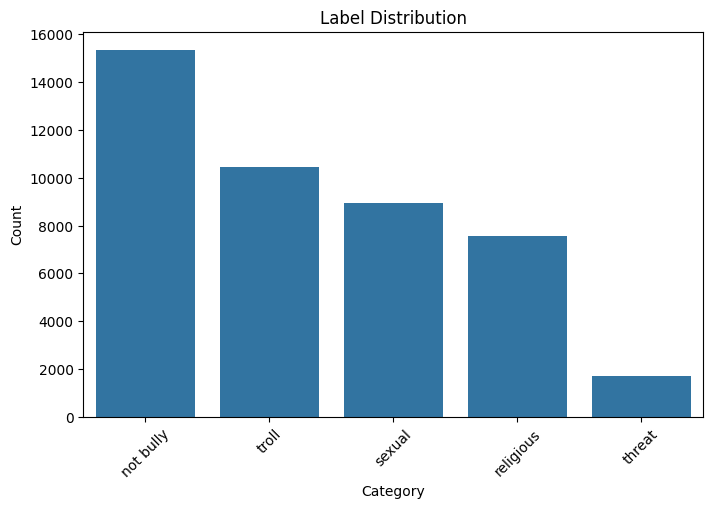

In [52]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8,5))
sns.countplot(x='label', data=df, order=df['label'].value_counts().index)
plt.title('Label Distribution')
plt.xlabel('Category')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

The bar chart above visualizes the distribution of comment categories (labels) in the dataset.
It shows how many samples belong to each class, helping to identify class imbalance and guiding model evaluation.
A balanced distribution is ideal for training, while significant imbalance may require techniques like resampling or class weighting.

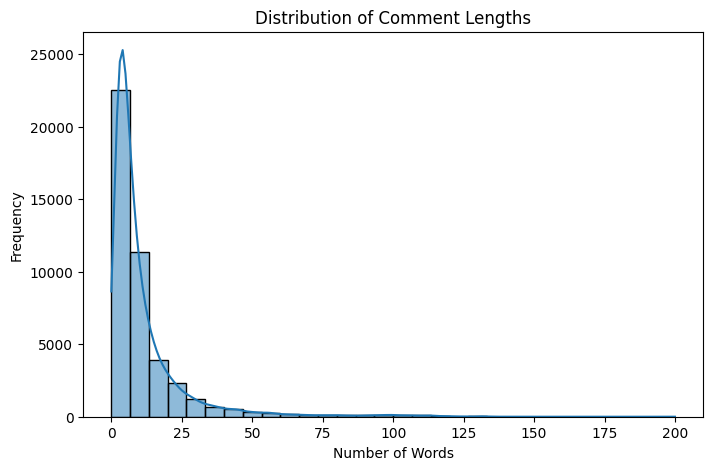

In [53]:
df['comment_length'] = df['cleaned_text'].apply(lambda x: len(x.split()))

plt.figure(figsize=(8,5))
sns.histplot(df['comment_length'], bins=30, kde=True)
plt.title('Distribution of Comment Lengths')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.show()

The diagram above illustrates the distribution of comment lengths after text preprocessing. It shows how many comments fall into different word count ranges, providing insight into the typical size and variability of comments in the dataset. This information helps in understanding the dataset's characteristics and can guide decisions on model input length and preprocessing strategies.

In [9]:
from transformers import BertTokenizer, BertModel
import torch

tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')
model = BertModel.from_pretrained('bert-base-multilingual-cased')
text = df['cleaned_text'][0]

inputs = tokenizer(text, 
                   return_tensors='pt',  # PyTorch tensors
                   max_length=128,       # max tokens
                   truncation=True,
                   padding='max_length')

with torch.no_grad():
    outputs = model(**inputs)
    
# Extract last hidden state embeddings for [CLS] token (sentence embedding)
cls_embedding = outputs.last_hidden_state[:,0,:]  # shape: [1, 768]


In [10]:
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')

# Tokenize all cleaned texts
encoded_inputs = tokenizer(
    list(df['cleaned_text']),
    return_tensors='pt',
    max_length=128,
    padding=True,
    truncation=True
)

# encoded_inputs is a dict with input_ids, attention_mask, etc.
print(encoded_inputs['input_ids'].shape)  # e.g., (num_samples, max_length)


torch.Size([44001, 128])


In [11]:
from transformers import BertTokenizer, BertModel
from torch.utils.data import DataLoader, Dataset

# Custom Dataset for texts
class TextDataset(Dataset):
    def __init__(self, texts):
        self.texts = texts
    
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        return self.texts[idx]

# Collate function to tokenize and pad batch
def collate_fn(batch):
    return tokenizer(batch,
                     return_tensors='pt',
                     padding='max_length',
                     truncation=True,
                     max_length=64)  # reduced max length for memory

# Initialize tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')
model = BertModel.from_pretrained('bert-base-multilingual-cased')

# Set device to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

model.to(device)
model.eval()

# Prepare dataset and dataloader with batch_size=1 to avoid OOM
dataset = TextDataset(list(df['cleaned_text']))
dataloader = DataLoader(dataset, batch_size=2, collate_fn=collate_fn)

all_embeddings = []

with torch.no_grad():
    for batch in dataloader:
        # Move batch tensors to device
        batch = {k: v.to(device) for k, v in batch.items()}
        
        outputs = model(**batch)
        cls_embeddings = outputs.last_hidden_state[:, 0, :]  # CLS token embedding
        
        # Move to CPU and convert to numpy
        all_embeddings.append(cls_embeddings.cpu().numpy())
        
        # Clear cache to avoid fragmentation and OOM
        torch.cuda.empty_cache()

# Stack all embeddings into one numpy array
all_embeddings = np.vstack(all_embeddings)
print(f"CLS embeddings shape: {all_embeddings.shape}")


Using device: cuda
CLS embeddings shape: (44001, 768)


This cell extracts sentence embeddings for each comment using the multilingual BERT model. It defines a custom PyTorch Dataset and DataLoader to efficiently batch and tokenize the cleaned texts. For each batch, the model computes the [CLS] token embeddings, which serve as fixed-length representations of the comments. These embeddings are collected into a NumPy array for downstream tasks such as classification or clustering. The process leverages GPU acceleration if available and includes memory management to avoid out-of-memory errors.

In [20]:
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset, random_split
from transformers import BertTokenizer, BertModel
from torch.optim import AdamW
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score

# Encode labels
label_encoder = LabelEncoder()
df['encoded_label'] = label_encoder.fit_transform(df['label'])

# Dataset
class TextDataset(Dataset):
    def __init__(self, texts, labels):
        self.texts = texts
        self.labels = labels

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        return self.texts[idx], self.labels[idx]

# Collate function
def collate_fn(batch):
    texts, labels = zip(*batch)
    tokens = tokenizer(list(texts),
                       return_tensors='pt',
                       padding='max_length',
                       truncation=True,
                       max_length=64)
    return tokens, torch.tensor(labels)

# Model
class BERTClassifier(nn.Module):
    def __init__(self, dropout=0.3):
        super(BERTClassifier, self).__init__()
        self.bert = BertModel.from_pretrained('bert-base-multilingual-cased')
        self.dropout = nn.Dropout(dropout)
        self.linear = nn.Linear(self.bert.config.hidden_size, len(label_encoder.classes_))

    def forward(self, input_ids, attention_mask, token_type_ids):
        outputs = self.bert(input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
        cls_output = outputs.last_hidden_state[:, 0, :]  # CLS token
        cls_output = self.dropout(cls_output)
        return self.linear(cls_output)

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')

# Data
dataset = TextDataset(df['cleaned_text'].tolist(), df['encoded_label'].tolist())
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_ds, val_ds = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_ds, batch_size=8, collate_fn=collate_fn, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=8, collate_fn=collate_fn)

# Model init
model = BERTClassifier().to(device)
optimizer = AdamW(model.parameters(), lr=2e-5)
criterion = nn.CrossEntropyLoss()

# Training
epochs = 3
for epoch in range(epochs):
    model.train()
    total_loss = 0
    for batch in train_loader:
        tokens, labels = batch
        tokens = {k: v.to(device) for k, v in tokens.items()}
        labels = labels.to(device)

        outputs = model(**tokens)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print(f"Epoch {epoch+1} | Loss: {total_loss:.4f}")

    # Validation
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for batch in val_loader:
            tokens, labels = batch
            tokens = {k: v.to(device) for k, v in tokens.items()}
            labels = labels.to(device)

            outputs = model(**tokens)
            preds = torch.argmax(outputs, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    acc = accuracy_score(all_labels, all_preds)
    print(f"Validation Accuracy: {acc:.4f}")


Using device: cuda
Epoch 1 | Loss: 3115.8625
Validation Accuracy: 0.8145
Epoch 2 | Loss: 2315.8419
Validation Accuracy: 0.8274
Epoch 3 | Loss: 2005.2618
Validation Accuracy: 0.8238


This cell defines and trains a custom BERT-based classifier for detecting cyberbullying categories in Bangla-English comments. It encodes the labels, prepares a PyTorch dataset and dataloaders, and implements a neural network that leverages the multilingual BERT model for feature extraction. The training loop optimizes the model using cross-entropy loss and AdamW optimizer, while validation accuracy is reported after each epoch. This setup enables robust classification of social media comments into multiple categories.

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

# After validation
print("Classification Report:")
print(classification_report(all_labels, all_preds, target_names=label_encoder.classes_))

print("Confusion Matrix:")
print(confusion_matrix(all_labels, all_preds))
# ...existing code...

Classification Report:
              precision    recall  f1-score   support

   not bully       0.84      0.84      0.84      3106
   religious       0.90      0.86      0.88      1549
      sexual       0.83      0.86      0.84      1814
      threat       0.76      0.66      0.70       319
       troll       0.74      0.76      0.75      2013

    accuracy                           0.82      8801
   macro avg       0.81      0.80      0.80      8801
weighted avg       0.82      0.82      0.82      8801

Confusion Matrix:
[[2624   54   85   16  327]
 [  72 1337   64   15   61]
 [  96   37 1553    9  119]
 [  42   20   12  210   35]
 [ 272   33  154   28 1526]]


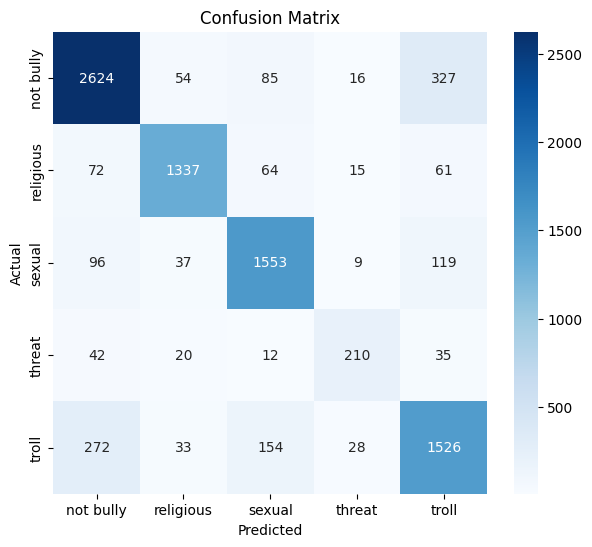

In [54]:
from sklearn.metrics import confusion_matrix
import numpy as np

cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(7,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

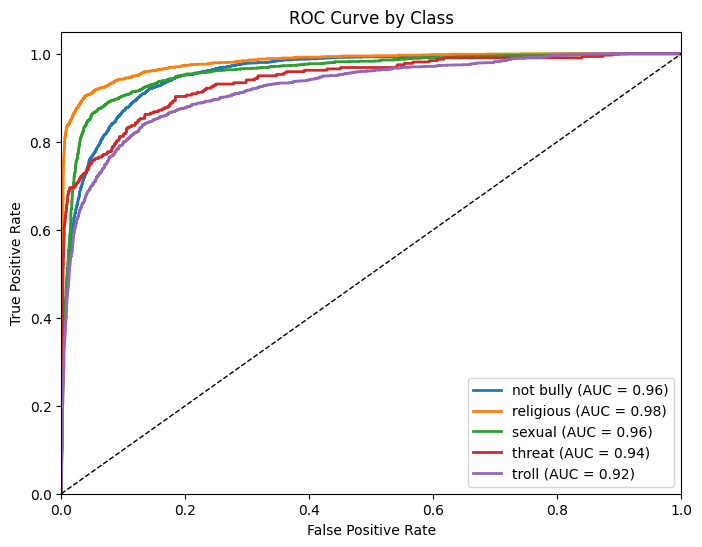

In [60]:
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.preprocessing import label_binarize

# Binarize the labels for multi-class ROC
n_classes = len(label_encoder.classes_)
y_true_bin = label_binarize(all_labels, classes=range(n_classes))

# Get predicted probabilities for each class
# outputs = model(**tokens) should give logits; apply softmax to get probabilities
# If you have all_probs from validation, use that. Otherwise, collect them during validation:
# all_probs = np.concatenate([torch.softmax(outputs, dim=1).cpu().numpy() for ...])

# Example: If you have all_probs as a list of arrays, stack them:
# all_probs = np.vstack(all_probs)

# If not, you can re-run validation to collect probabilities:
all_probs = []
model.eval()
with torch.no_grad():
    for batch in val_loader:
        tokens, labels = batch
        tokens = {k: v.to(device) for k, v in tokens.items()}
        outputs = model(**tokens)
        probs = torch.softmax(outputs, dim=1)
        all_probs.append(probs.cpu().numpy())
all_probs = np.vstack(all_probs)

# Plot ROC curve for each class
plt.figure(figsize=(8,6))
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], all_probs[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'{label_encoder.classes_[i]} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve by Class')
plt.legend(loc="lower right")
plt.show()

The ROC curve above illustrates the performance of the classifier for each comment category. For each class, the curve plots the True Positive Rate (sensitivity) against the False Positive Rate (1 - specificity) at various threshold settings. The Area Under the Curve (AUC) value for each class quantifies the model's ability to distinguish between categories: a higher AUC indicates better discrimination. These curves help assess how well the model separates cyberbullying categories and can guide further improvements or threshold selection.

In [ ]:
def predict_comment_category(comment):
    # Clean the input comment (same cleaning as training, including stopwords removal if used)
    cleaned = clean_mixed_text(comment)
    # Tokenize
    tokens = tokenizer([cleaned],
                       return_tensors='pt',
                       padding='max_length',
                       truncation=True,
                       max_length=64)
    # Move tensors to device
    tokens = {k: v.to(device) for k, v in tokens.items()}
    # Predict
    model.eval()
    with torch.no_grad():
        outputs = model(**tokens)
        pred = torch.argmax(outputs, dim=1).cpu().numpy()[0]
    # Decode label
    return label_encoder.inverse_transform([pred])[0]

# Example usage:
fb_comment = "তারপর দুজনে ধপাস করে পড়ে যাওয়া 🤭"
category = predict_comment_category(fb_comment)
print(f"Predicted category: {category}")

Predicted category: not bully


In [49]:
test_comments = [
"you are so stupid."
]

for comment in test_comments:
    category = predict_comment_category(comment)
    print(f"Comment: {comment}\nPredicted Category: {category}\n")

Comment: you are so stupid.
Predicted Category: not bully



In [50]:
import pickle

# Save the model's state dict (weights)
torch.save(model.state_dict(), "bert_classifier_state_dict.pth")

# Save the tokenizer files
tokenizer.save_pretrained("saved_tokenizer")

# Save the label encoder
with open('label_encoder.pkl', 'wb') as f:
    pickle.dump(label_encoder, f)

print("Model, tokenizer, and label encoder saved successfully!")


Model, tokenizer, and label encoder saved successfully!


In [51]:
import pickle

# Save the DataFrame with cleaned text to a pickle file
with open('preprocessed_comments.pkl', 'wb') as f:
    pickle.dump(df, f)

print("Preprocessed data saved to preprocessed_comments.pkl")

Preprocessed data saved to preprocessed_comments.pkl
